In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
abundance_df = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [4]:
data_df = binding_df.copy()
y_cols = data_df.columns[1:] 

In [5]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [7]:
data_df_GE = binding_df_full[['aa_seq','fitness']].copy()

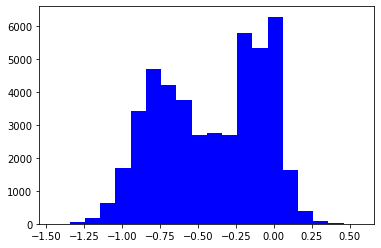

In [8]:
plt.hist(data_df_GE['fitness'],bins=20,color='blue')
plt.show()

In [9]:
#gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

gpmapGE = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
                                              alphabet=alphabet,
                                              number_latent_nodes=2)

#gpmapGE = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsistasisMP(K=50,
                                                           monotonic=True,
                                                           number_latent_nodes=2,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [10]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [11]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

2023-01-26 08:03:50.572073: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


N = 41,749 observations set as training data.
Using 20.0% for validation.
Time to set data: 1.38 sec.


In [12]:
model_GE.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 1198)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 1197)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 multi__additive_gp_map_layer (  (None, 2)           2396        ['Sequence_only[0][0]']          
 Multi_AdditiveGPMapLayer)                                                                        
                                                                                              

In [13]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=150,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/150
112/112 [==============================] - 2s 6ms/step - loss: 258.7858 - I_var: -1.0143 - val_loss: 245.3947 - val_I_var: -0.9521
Epoch 2/150
112/112 [==============================] - 0s 4ms/step - loss: 232.2683 - I_var: -0.8865 - val_loss: 217.1174 - val_I_var: -0.8157
Epoch 3/150
112/112 [==============================] - 0s 4ms/step - loss: 199.7713 - I_var: -0.7296 - val_loss: 180.3073 - val_I_var: -0.6380
Epoch 4/150
112/112 [==============================] - 0s 4ms/step - loss: 162.3992 - I_var: -0.5498 - val_loss: 144.1238 - val_I_var: -0.4634
Epoch 5/150
112/112 [==============================] - 0s 4ms/step - loss: 128.0048 - I_var: -0.3840 - val_loss: 112.3411 - val_I_var: -0.3100
Epoch 6/150
112/112 [==============================] - 0s 4ms/step - loss: 97.7084 - I_var: -0.2386 - val_loss: 84.6994 - val_I_var: -0.1766
Epoch 7/150
112/112 [==============================] - 0s 4ms/step - loss: 71.9443 - I_var: -0.1149 - val_loss: 60.8839 - val_I_var: -0.0617
Epo

112/112 [==============================] - 0s 4ms/step - loss: -161.9463 - I_var: 1.0130 - val_loss: -142.2161 - val_I_var: 0.9186
Epoch 59/150
112/112 [==============================] - 0s 4ms/step - loss: -162.5024 - I_var: 1.0126 - val_loss: -143.0742 - val_I_var: 0.9228
Epoch 60/150
112/112 [==============================] - 0s 4ms/step - loss: -163.2668 - I_var: 1.0189 - val_loss: -143.4724 - val_I_var: 0.9247
Epoch 61/150
112/112 [==============================] - 0s 4ms/step - loss: -164.1487 - I_var: 1.0226 - val_loss: -145.2103 - val_I_var: 0.9331
Epoch 62/150
112/112 [==============================] - 0s 4ms/step - loss: -164.0474 - I_var: 1.0221 - val_loss: -141.8680 - val_I_var: 0.9171
Epoch 63/150
112/112 [==============================] - 0s 4ms/step - loss: -164.9215 - I_var: 1.0268 - val_loss: -145.5807 - val_I_var: 0.9349
Epoch 64/150
112/112 [==============================] - 0s 4ms/step - loss: -165.8442 - I_var: 1.0289 - val_loss: -146.4751 - val_I_var: 0.9393
Epoch

Epoch 115/150
112/112 [==============================] - 1s 7ms/step - loss: -182.4697 - I_var: 1.1102 - val_loss: -160.9588 - val_I_var: 1.0094
Epoch 116/150
112/112 [==============================] - 1s 7ms/step - loss: -181.0832 - I_var: 1.1058 - val_loss: -159.1999 - val_I_var: 1.0010
Epoch 117/150
112/112 [==============================] - 1s 7ms/step - loss: -182.3065 - I_var: 1.1105 - val_loss: -159.3808 - val_I_var: 1.0017
Epoch 118/150
112/112 [==============================] - 1s 7ms/step - loss: -182.5175 - I_var: 1.1130 - val_loss: -160.9473 - val_I_var: 1.0093
Epoch 119/150
112/112 [==============================] - 1s 8ms/step - loss: -182.9160 - I_var: 1.1070 - val_loss: -160.7438 - val_I_var: 1.0084
Epoch 120/150
112/112 [==============================] - 1s 7ms/step - loss: -181.8691 - I_var: 1.1071 - val_loss: -161.0869 - val_I_var: 1.0100
Epoch 121/150
112/112 [==============================] - 1s 7ms/step - loss: -182.8723 - I_var: 1.1134 - val_loss: -160.2299 - val

On test data:


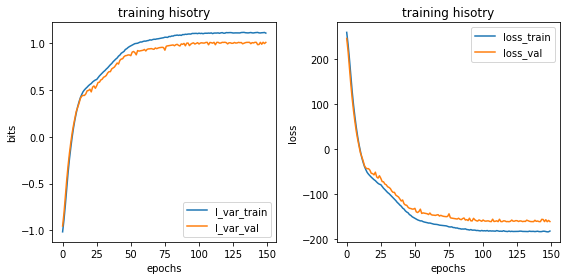

In [14]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [16]:
# phi = gpmapGE.x_to_phi(x_test_GE)
# phi_train = gpmapGE.x_to_phi(x_train_GE)

In [22]:
model_GE.model.predict

<bound method Model.predict of <keras.engine.functional.Functional object at 0x7f9341249be0>>

In [ ]:
np.corrcoef(phi_train,y_train_GE)[0,1]**2

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(9,4.5))

ax = axs[0]
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter(phi,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
#ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')
ax.scatter(phi,yhat,s=2,alpha=0.3,c='r',label='$\hat{y} = g(\phi)$')

ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('GRB2-SH3 - binding')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax = axs[1]
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'GRB2-SH3, $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
#fig.savefig('plots/GRB2_SH3/global_epistasis_binding_binding.png',dpi=300,bbox_inches='tight')    


In [ ]:
theta_lc_GE = gpmapGE.get_theta(model_GE,gauge='consensus')['theta_lc']

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(theta_2_lc[0].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[0].set_xlabel('Theta-1 multi-discrete monotonic')
ax[0].set_ylabel('Theta global epistasis')

ax[1].scatter(theta_2_lc[1].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[1].set_xlabel('Theta-2 multi-discrete monotonic')
ax[1].set_ylabel('Theta global epistasis')

fig.tight_layout()

In [ ]:
lehner_binding_singles_df = pd.read_csv('data/GRB2-SH3.singles_binding.csv',index_col=[0])
lehner_binding_singles_df

In [ ]:
binding_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
binding_singles_transformed_df.head()

In [ ]:
for idx in lehner_binding_singles_df.index:

    mutant = lehner_binding_singles_df.loc[idx]['Mut']
    value = lehner_binding_singles_df.loc[idx]['fitness']
    
    pos = lehner_binding_singles_df.loc[idx]['Pos']-1
    binding_singles_transformed_df[mutant][pos] = value

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_2_lc[0].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[0].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 1')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_2_lc[1].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[1].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 2')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

#fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_binding_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


In [ ]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=binding_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - binding')

#fig.savefig('plots/GRB2_SH3/Lehner_GP_map_binding.png',dpi=300,bbox_inches='tight')